# **Chapter 4: Training Models**
* Linear Regression beserta algoritma pelatihannya
* Variasi Gradient Descent
* Polynomial Regression
* Regularisasi: Ridge, Lasso, dan Elastic Net
* Logistic Regression
* Softmax Regression

# **Overview**
Memahami bagaimana model machine learning dilatih sangat penting untuk:
* memilih model yang tepat,
* melakukan tuning hyperparameter,
* melakukan debugging model,
* serta meningkatkan performa model secara keseluruhan.

inear Regression Model
Model regresi linier memprediksi output y sebagai hasil penjumlahan berbobot dari fitur input ditambah bias.

$$ y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n $$

Keterangan:

- \$ \hat{y} \$ = nilai prediksi
- \$ x_i \$ = nilai fitur
- \$ \theta_j \$ = parameter model (bobot dan bias)

Dalam bentuk vektor:
$$ \hat{y} = h_{\theta}(x) = \theta^T x $$
Dengan
- \$ x_0 = 1 \$ untuk menyertakan bias.

Model dilatih dengan meminimalkan Mean Squared Error (MSE) antara prediksi dan nilai asli.

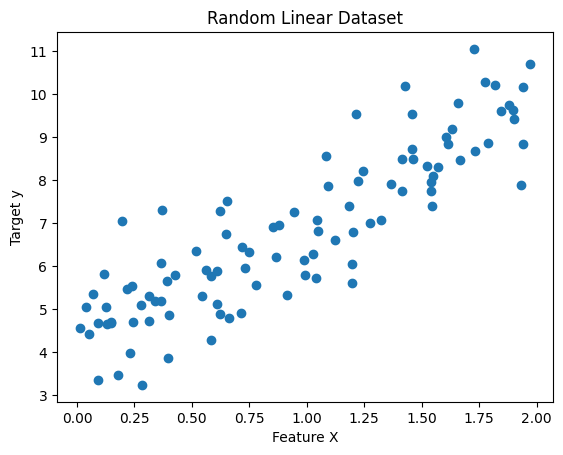

In [1]:
# Contoh: Membuat dataset linear sederhana
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
m = 100  # jumlah data
X = 2 * np.random.rand(m, 1)
y = 4 + 3 * X + np.random.randn(m, 1)  # target dengan noise

plt.scatter(X, y)
plt.xlabel('Feature X')
plt.ylabel('Target y')
plt.title('Random Linear Dataset')
plt.show()


# **Training Linear Regression**
## **2.1 Normal Equation (Solusi Tertutup)**
Solusi matematis langsung untuk 𝜃 yang meminimalkan fungsi cost MSE:

$$ \theta = (X^T X)^{-1} X^T y $$

X adalah matriks fitur dengan kolom pertama diisi 1 untuk bias. Metode ini cepat untuk dataset kecil, tapi mahal untuk dataset besar (kompleksitas
\$ O(n^2.4) \text{ to } O(n^3) \$ ).

In [2]:
X_b = np.c_[np.ones((m, 1)), X]  # tambahkan x0 = 1 untuk bias
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

print("Theta computed from Normal Equation:\n", theta_best)


Theta computed from Normal Equation:
 [[4.21509616]
 [2.77011339]]


## **2.2 Menggunakan Scikit-Learn**
Scikit-Learn menyediakan antarmuka sederhana untuk melatih model regresi linier menggunakan metode numerik efisien (SVD).

In [3]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

print(f"Intercept: {lin_reg.intercept_}")
print(f"Coefficients: {lin_reg.coef_}")


Intercept: [4.21509616]
Coefficients: [[2.77011339]]


Gradient Descent
Alih-alih menyelesaikan persamaan matriks, Gradient Descent (GD) memperbarui parameter secara bertahap menggunakan arah negatif dari turunan fungsi cost.

Langkah-langkah:
* Mulai dari 𝜃 acak
* Hitung gradien $$\nabla_{\theta} \text{MSE}$$
* Update:
\$ \theta \leftarrow \theta - \eta \times \nabla_{\theta} \text{MSE} \$, dengan \$ \eta \$ adalah learning rate
* Ulangi hingga konvergen
Turunan dari fungsi MSE:
$$ \nabla_{\theta} \text{MSE} = \frac{2}{m} X^T (X \theta - y) $$

In [4]:
eta = 0.1  # learning rate
n_iterations = 1000
theta = np.random.randn(2, 1)  # inisialisasi acak

for iteration in range(n_iterations):
    gradients = 2 / m * X_b.T.dot(X_b.dot(theta) - y)
    theta -= eta * gradients

print("Theta found by Gradient Descent:\n", theta)


Theta found by Gradient Descent:
 [[4.21509616]
 [2.77011339]]


# **Gradient Descent Variants**
**a) Batch Gradient Descent**
Menggunakan seluruh dataset untuk menghitung gradien pada setiap iterasi. Akurat tapi lambat untuk dataset besar.

**b) Stochastic Gradient Descent (SGD)**
Menggunakan satu instance acak tiap iterasi. Lebih cepat dan cocok untuk dataset besar, tapi hasil bisa fluktuatif.

**c) Mini-batch Gradient Descent**
Kompromi antara batch dan stochastic — menggunakan subset kecil. Lebih stabil dan efisien, sering digunakan pada deep learning.

In [5]:
# Contoh Stochastic Gradient Descent
n_epochs = 50
t0, t1 = 5, 50  # parameter untuk learning rate schedule

def learning_schedule(t):
    return t0 / (t + t1)

theta_sgd = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        idx = np.random.randint(m)
        xi = X_b[idx:idx+1]
        yi = y[idx:idx+1]
        gradients = 2 * xi.T.dot(xi.dot(theta_sgd) - yi)
        eta = learning_schedule(epoch * m + i)
        theta_sgd -= eta * gradients

print("Theta found by Stochastic Gradient Descent:\n", theta_sgd)


Theta found by Stochastic Gradient Descent:
 [[4.18475289]
 [2.73036719]]


Polynomial Regression
Untuk menangani data non-linier dengan model linear, kita dapat menambahkan fitur berpangkat

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

m = 100
X_nl = 6 * np.random.rand(m, 1) - 3
y_nl = 0.5 * X_nl**2 + X_nl + 2 + np.random.randn(m, 1)

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X_nl)

lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_poly, y_nl)

print("Intercept:", lin_reg_poly.intercept_)
print("Coefficients:", lin_reg_poly.coef_)


Intercept: [1.8699327]
Coefficients: [[0.99763195 0.51104433]]


# **Learning Curves**
Learning curve adalah grafik error terhadap ukuran data latih.
* Underfitting: error tinggi pada train dan val, grafik saling dekat
* Overfitting: error train rendah, val tinggi, gap besar

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_errors, val_errors = [], []

    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_val_pred = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        val_errors.append(mean_squared_error(y_val, y_val_pred))

    plt.plot(np.sqrt(train_errors), "r--", label="Train")
    plt.plot(np.sqrt(val_errors), "b-", label="Validation")
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.title("Learning Curves")
    plt.legend()
    plt.show()


# **Regularization**
Regularisasi membantu mencegah overfitting dengan membatasi besar bobot parameter.

**a) Ridge Regression (L2)**

Menambahkan penalti kuadrat bobot:
$$ \alpha \sum_{i=1}^n \theta_i^2 $$

**b) Lasso Regression (L1)**

Penalti absolut bobot:
$$  \alpha \sum_{i=1}^n |\theta_i| $$
Bisa menghasilkan sparsity (beberapa bobot = 0).

**c) Elastic Net**

Kombinasi L1 dan L2, dikendalikan dengan rasio
𝑟.

# **Early Stopping**
Teknik regularisasi yang menghentikan pelatihan saat error validasi tidak membaik lagi.
Menghindari overfitting, dan menyimpan model terbaik selama pelatihan.



 Logistic Regression
Digunakan untuk klasifikasi biner.
Mengestimasi probabilitas p bahwa suatu instance termasuk dalam kelas positif:
$$ p = h_{\theta}(x) = \sigma(\theta^T x) = \frac{1}{1 + e^{-\theta^T x}} $$
Prediksi:
* Prediksi 1 jika 𝑝 ≥ 0.5
* Prediksi 0 jika 𝑝 < 0.5
Fungsi kerugian: Log loss (cross-entropy):
$$ J(\theta) = - \frac{1}{m} \sum_{i=1}^m \left[ y_i \log p_i + (1-y_i) \log (1-p_i) \right] $$
Tidak memiliki solusi tertutup, dilatih dengan Gradient Descent.

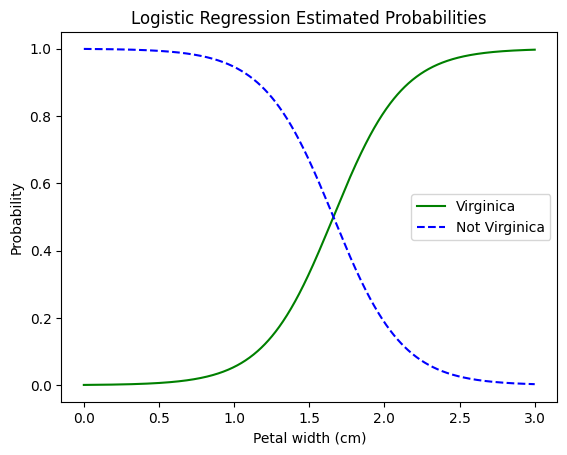

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

iris = datasets.load_iris()
X_log = iris['data'][:, 3:]  # lebar kelopak
y_log = (iris['target'] == 2).astype(int)  # target: virginica?

log_reg = LogisticRegression()
log_reg.fit(X_log, y_log)

import matplotlib.pyplot as plt
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", label="Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Virginica")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.title("Logistic Regression Estimated Probabilities")
plt.legend()
plt.show()


# **Softmax Regression**
Softmax Regression adalah perluasan dari Logistic Regression untuk masalah klasifikasi multikelas.

Model ini menghitung skor untuk setiap kelas, lalu menerapkan fungsi softmax agar skor tersebut berubah menjadi probabilitas

$$ p_k = \frac{e^{s_k(x)}}{\sum_{j=1}^K e^{s_j(x)}} $$

* $$ s_k(x) = \theta_k^T x $$ adalah skor untuk kelas ke-
𝑘
* $$ p_k $$ adalah probabilitas bahwa input termasuk ke dalam kelas
𝑘
* K adalah jumlah kelas

Model memprediksi kelas dengan probabilitas tertinggi.
Pelatihan dilakukan dengan meminimalkan cross-entropy loss di semua kelas.



In [9]:
# Softmax Regression untuk klasifikasi multikelas
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

iris = datasets.load_iris()
X_multi = iris['data'][:, (2, 3)]  # gunakan panjang & lebar kelopak
y_multi = iris['target']           # 3 kelas target

softmax_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_model.fit(X_multi, y_multi)

# Prediksi kelas dan probabilitas untuk bunga dengan ukuran tertentu
sample = [[5, 2]]
pred_class = softmax_model.predict(sample)
pred_probs = softmax_model.predict_proba(sample)

print(f"Prediksi kelas untuk bunga 5cm x 2cm: {pred_class}")
print(f"Probabilitas tiap kelas: {pred_probs}")


Prediksi kelas untuk bunga 5cm x 2cm: [2]
Probabilitas tiap kelas: [[6.21626374e-07 5.73689802e-02 9.42630398e-01]]


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
